In [32]:
import torch
import torch.nn as nn
import torch.fx as fx
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Loading data and Defining transformation needed

In [8]:
DATA_ROOT = "./data"
tx = transforms.ToTensor()

Initializing training dataset. (flag train refers to training set)

In [9]:
train_ds = datasets.MNIST(
    root=DATA_ROOT,
    train=True,
    transform=tx,
    download=True
)
print(len(train_ds))

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 721kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 6.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]

60000


Defining dataloader for training, with batch size being 64 and shuffling

In [14]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

In [15]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


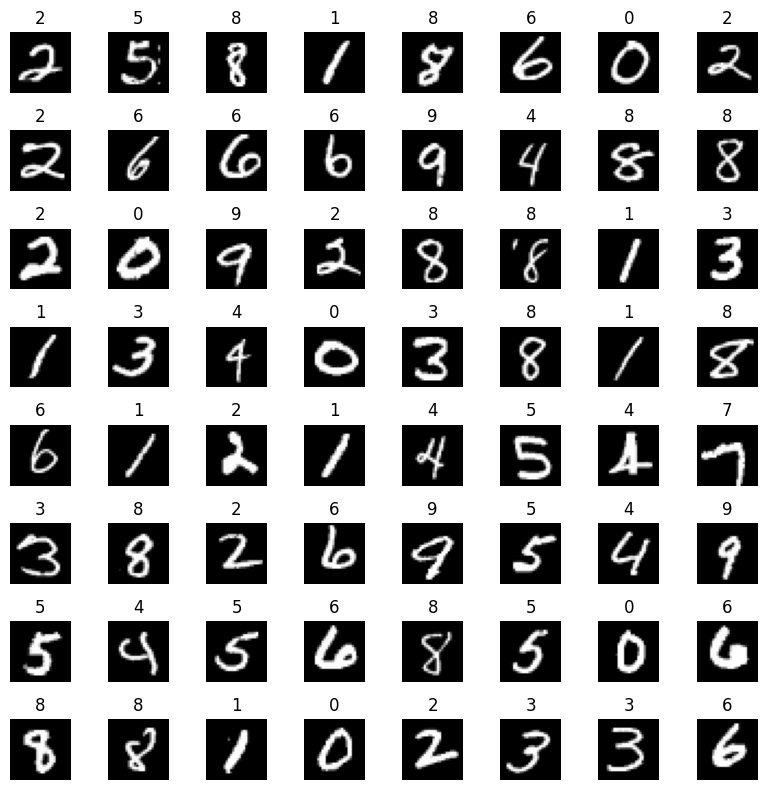

In [20]:
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(0), cmap="gray")
    plt.title(int(labels[i]))

plt.tight_layout()
plt.show()

In [41]:
class MINSTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128) # (28, 28) -> 128
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # 128 -> 10

    def forward(self, x):
        # view changes the dimension while fixing the ordering of the pixels, "-1" is for auto calculation in dimension
        x = x.view(x.size(0), -1) # this requires (batch size, 784) of data, so have to send entire image in all at once
        fc1 = self.fc1(x)
        relu = self.relu(fc1)
        fc2 = self.fc2(relu)
        return fc2

net = MINSTClassifier()
print(net)
test_result = net.forward(images.squeeze(0))
print(test_result.shape)

MINSTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
torch.Size([64, 10])
